# Probabilistic Programming - 3: Hidden Markov modeling
## Monte Carlo sampling

In this notebook, we will be looking at forecasting a time-series. To be precise, we will implement a Hidden Markov Model using Turing.

### Preliminaries

- Goal 
  - Learn to apply Turing to a time-series data set.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Tutorial on HMM using [Turing.jl](https://turing.ml/dev/tutorials/4-bayeshmm/)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
# Package managing
# using Pkg
# Pkg.activate("workspace")
# Pkg.instantiate()

using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots

### Data generation

In this problem setting, data is generated in the form of states over time. For example, proteins that fold into one of several functional configurations or machine translation, where one observes writing in one language and aims to infer writing in another language (both being finite sets of symbols). We don't have perfect measurement tools and have to assume measurement noise. 

We will generate a synthetic data set as follows: we pick an initial state and evolve the state using a fixed state transition matrix. Then we observe the state using a fixed observation probability, referred to as an _emission_ matrix. 

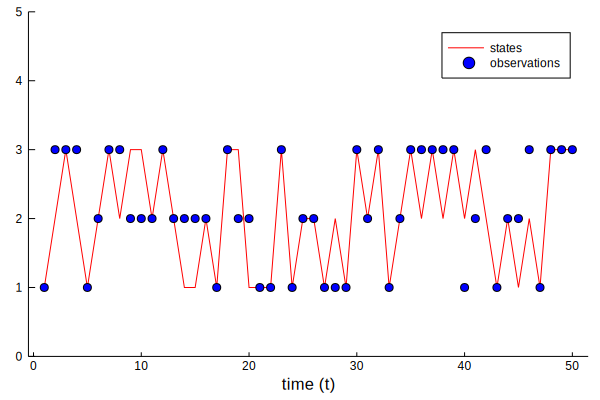

In [16]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3 0.6 0.1; 
              0.5 0.2 0.3; 
              0.2 0.8 0.1]

# Emission matrix for observed variables
emission = [0.7 0.3 0.0; 
            0.2 0.6 0.2; 
            0.0 0.3 0.7]

# Preallocate data arrays
states = Array{Int64,1}(undef, T+1)
observations = Array{Int64,1}(undef, T)

# Initial state
states[1] = 1

# Generate data for entire time-series
for t = 2:T+1
    
    # Transition from previous state
    Ax = transition[:, states[t-1]]
    
    # Sample from Categorical distribution
    states[t] = rand(Categorical(Ax ./ sum(Ax)), 1)[1]
    
    # Emission of current state
    Bx = emission[:, states[t]]
    
    # Sample from Categorical distribution
    observations[t-1] = rand(Categorical(Bx ./ sum(Bx)), 1)[1]
    
end

# Visualization.
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 5), grid=false)
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

## Model Specification

The Hidden Markov model is a state-space model of the form:

$$\begin{align}
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \text{Cat}(B x_t)
\end{align}$$

where $A$ is the state transition matrix and $B$ is the emission matrix. The states $x$ are indexed by time $t$, ranging from $0$ to $T$. The observations $y$ are indexed from $1$ to $T$. 

In [3]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff)
include("../scripts/pp-3.jl");

Again, we start simple and slowly improve the model.

### Model 1: estimate states

We will first assume we know the transition and emission matrices. Based on these, we purely want to estimate states from observations.

In [18]:
# Turing model definition.
@model HMM(y, K, A, B) = begin
    
    # Get observation length.
    N = length(y)

    # State sequence.
    x = Vector{Int}(undef, N+1)

    # Define initial state
    x[1] ~ Categorical(ones(K,)./K)

    # Loop over entire sequence
    for t = 2:N+1
        
        # Transition states
        Ax = A[:, x[t-1]]
        
        # State transition     
        x[t] ~ Categorical(Ax / sum(Ax))
        
        # Emit states
        Bx = B[:, x[t]]
        
        # Observation emission
        y[t-1] ~ Categorical(Bx / sum(Bx))
    end
end;

# Call instance of the model
model = HMM(observations, K, transition, emission);

The Categorical distribution is a known parametric distribution, which we can marginalize. It is therefore suited to Gibbs sampling.

In [19]:
# Length of chain
len_chain = 100

# Define sampler
sampler = Gibbs(PG(50, :x))

# Call sampler
chain = sample(model, sampler, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


Let's inspect the chain again. Note that $x$ is an array of $T$ latent variables, so this will take some time.

In [ ]:
plot(chain[:x])

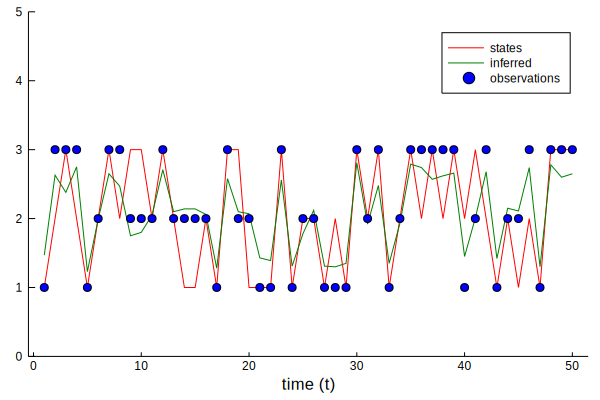

In [23]:
# Extract mean of chain
x_hat = mean_chain(chain, :x)

# Visualization
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_hat[2:end], color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

### Assignment: transition matrix estimation

At the moment, we assume we know how the states evolve over time. This is not an unreasonable assumption; in protein folding we know exactly _how_ the protein changes state, i.e. through the signaling of another molecule, and we know the concentration of signal molecules. However, in other applications we do not necessarily know the transition matrix. 

We can estimate the transition matrix by letting them be latent variable and posing a prior.

In [9]:
### Your code here

### Assignment: continuous observations

We can extend the problem setting to one where the states are discrete, but the observations are continuous. Think for example of speech recognition. There are a finite set of syllables that can be uttered, but each person does this in a slightly different way. 

Given the following data set, can you change the model such that it infers the discrete states from continuous observations?

In [10]:
### Your code here